# Problem Set 4, due February 23 at 11:59am, mid-day, noon.

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions.
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 3.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm # for OLS

import math # for e constant

In [2]:
# Initial data load
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Getting oriented

Use different learning rates

### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  Interpret your results.

In [3]:
print bdata.feature_names


['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [4]:
# uncomment the following if you want to see a lengthy description of the dataset
# print bdata.keys()
# print bdata.feature_names
# print bdata.data.shape
# print bdata.target.shape
# print bdata.DESCR


# assign x,y for regression
y = np.vstack(bdata.target)
x = np.vstack(bdata.data[:,5]) # rm

# check for nan
if any(np.isnan(x)): print  'x has nan value(s)'
if any(np.isnan(y)): print 'y has nan value(s)'

# check shapes
print x.shape, type(x)
print y.shape, type(y)

# simple linear regression target on rm
lm = LinearRegression(fit_intercept=True)
lm.fit(x, y)

# for use in later questions
rm_coeff = lm.coef_[0][0] 
rm_int = lm.intercept_ 

print 'rm coefficient: ', lm.coef_
print 'intercept: ', lm.intercept_
print("Residual sum of squares: %.2f"
      % np.mean((lm.predict(x) - y) ** 2))

# create rm2 values
x2 = x**2
x2 = np.concatenate((x, x2), axis=1)
# build df to pass rm, rm2 to lm
#bdf_rm2 = pd.DataFrame({'rm': bdf.rm, 'rm2': x2})

# regression target on rm + rm^2
lm.fit(x2, y)

print 'rm and rm^2 coefficients: ', lm.coef_
print 'intercept: ', lm.intercept_
print("Residual sum of squares: %.2f"
      % np.mean((lm.predict(x2) - y) ** 2))

# for use in later questions
sqrm_coeff = lm.coef_[0][0]
sqrm2_coeff = lm.coef_[0][1]
sqrm_int = lm.intercept_


(506, 1) <type 'numpy.ndarray'>
(506, 1) <type 'numpy.ndarray'>
rm coefficient:  [[ 9.10210898]]
intercept:  [-34.67062078]
Residual sum of squares: 43.60
rm and rm^2 coefficients:  [[-22.64326237   2.47012384]]
intercept:  [ 66.05884748]
Residual sum of squares: 38.12


/Users/Brett/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In the simple linear regression model of rm on medv, an increase of 1 room corresponds to an increase of $9,102 in median home value. The intercept is negative because it is outside of the data space. (A home with zero rooms is not a home). The squared room model is a bit more difficult to interpret, as it is non-linear. It produces an exponentially increasing slope after about 5 rooms. The squared model does fit the data better, with a lower RSS (38.12 vs 43.60). This may be overfit, as the model was fit on the entire set.

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 250-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the 250 slope coefficients using a histogram with 25 bins, then draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you notice?

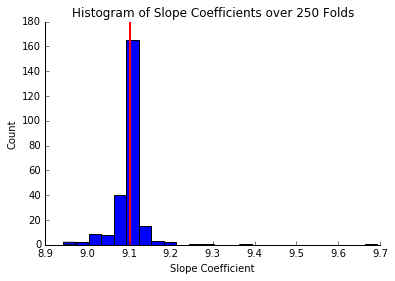

In [5]:
from sklearn.cross_validation import KFold

# initialize variables
kf = KFold(len(x), n_folds=250)
slopes = []
intercepts = []

# fit linear regression across k folds
for train_ix, test_ix in kf:
    x = np.vstack(bdata.data[train_ix,5])
    y = np.vstack(bdata.target[train_ix])
    lm.fit(x, y)
    slopes.append(lm.coef_[0][0])
    
# plot the histogram  
plt.hist(slopes, 25)
# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off

# apply labels
plt.gca().set_xlabel('Slope Coefficient')
plt.gca().set_ylabel('Count')
plt.gca().set_title('Histogram of Slope Coefficients over 250 Folds')

# add vertical line
plt.axvline(x=rm_coeff, linewidth=2, color='red')


The distribution of slopes produced by cross validation is fairly narrow, and seems to agree with the slope produced by regressing the whole dataset.

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

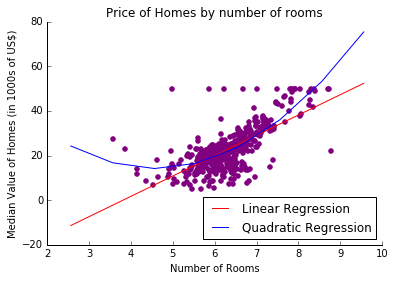

In [6]:
# set variables for plot
y = np.vstack(bdata.target)
x = np.vstack(bdata.data[:,5]) # rm

# create scatter plot of price on rooms per house
plt.scatter(x, y, color = 'purple')

# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off
# set x axis limits
plt.gca().set_xlim([2,10])
# apply labels
plt.gca().set_xlabel('Number of Rooms')
plt.gca().set_ylabel('Median Value of Homes (in 1000s of US$)')
plt.gca().set_title('Price of Homes by number of rooms')


X = np.arange(x.min()-1, x.max()+1)

plt.plot(X, X*rm_coeff + rm_int, 'r', label='Linear Regression')
plt.plot(X, X**2*sqrm2_coeff + X*sqrm_coeff + sqrm_int, 'b', label = 'Quadratic Regression')
plt.legend(loc='lower right')
#plt.plot(x, m*x + b, '-')

## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (Average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: Some people like to include a MaxIterations parameter in their gradient descent algorithm, to prevent divergence. *

In [7]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    co-efficient
"""
def bivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000):
    # initialize the parameters
    start_time = time.time()
    alpha = 0.0
    beta = 0.0
    M = 0
    J_alpha = 0.1
    J_beta = 0.1
    
    # loop until MaxIterations reached, or J-thetas become really small
    while M < MaxIterations and (abs(J_alpha) > .0001 or abs(J_beta) > .0001):
        
        # calculate residual and J-thetas
        resid = alpha + beta * xvalues - y
        J_alpha = np.mean(resid)
        J_beta = np.mean(resid*x)
        
        # update coefficients
        if abs(J_alpha) > .0001:
            alpha = alpha - R * J_alpha
        if abs(J_beta) > .0001:
            beta = beta - R * J_beta
        M += 1  

    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return alpha, beta, M

# call function for different values of R
for learningrate in range(1,10,1):
    intercept, coeff, count = bivariate_ols(x, y, learningrate*.01, 100000)
    print 'For R = %.2f, Intercept: %f, Beta coefficient: %f, Number of iterations: %i' \
    % (learningrate*.01, intercept, coeff, count)

Time taken: 2.82 seconds
For R = 0.01, Intercept: -34.661257, Beta coefficient: 9.100635, Number of iterations: 69043
Time taken: 1.36 seconds
For R = 0.02, Intercept: -34.661336, Beta coefficient: 9.100647, Number of iterations: 34513
Time taken: 0.91 seconds
For R = 0.03, Intercept: -34.661453, Beta coefficient: 9.100666, Number of iterations: 22998
Time taken: 0.68 seconds
For R = 0.04, Intercept: -34.661505, Beta coefficient: 9.100674, Number of iterations: 17220
Time taken: 0.59 seconds
For R = 0.05, Intercept: inf, Beta coefficient: nan, Number of iterations: 14646
Time taken: 0.08 seconds
For R = 0.06, Intercept: inf, Beta coefficient: nan, Number of iterations: 1854
Time taken: 0.05 seconds
For R = 0.07, Intercept: -inf, Beta coefficient: nan, Number of iterations: 1121
Time taken: 0.04 seconds
For R = 0.08, Intercept: inf, Beta coefficient: nan, Number of iterations: 852
Time taken: 0.03 seconds
For R = 0.09, Intercept: inf, Beta coefficient: nan, Number of iterations: 710


This gradient descent regression agrees with sklearn's LinearRegression function from above, producing intercept = -34.7 and coefficient = 9.1, though mine took a little longer to compute. The R value can make the funciton converge more quickly with higher values (as seen in R = .01 to .04), but too high a value (R>.04) will cause it to diverge and not return intercept or coefficient values.

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [8]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [9]:
# initialize and standardize variables for regression
y = np.ravel(np.vstack(standardize(bdata.target)))
x = np.vstack(standardize(bdata.data[:,5])) # rm
c = np.vstack(standardize(bdata.data[:,0])) # crim
xvalue_matrix = np.concatenate((x,c), axis = 1)

"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variables
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):

    # initialize the parameters
    start_time = time.time()
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)
    alpha = 0.0
    rows, features = xvalue_matrix.shape
    betas = np.zeros(features)
    M = 0
    J_alpha = 0.1
    J_betas = np.zeros(features)
    limit = .0000001

    # loop until MaxIterations reached, or J-thetas become really small
    while M < MaxIterations and (abs(J_alpha) > limit or abs(J_betas.max()) > limit):
        
        # calculate residual and J-thetas
        resid = alpha + np.dot(betas, xvalue_matrix.T) - yvalues
        J_alpha = np.mean(resid)
        J_betas = np.mean(np.multiply(xvalue_matrix.T, resid), axis = 1)

        # update coefficients
        if abs(J_alpha) > limit:
            alpha = alpha - R * J_alpha
        if abs(J_betas.max()) > limit:
            betas = betas - R * J_betas

        M += 1  
        
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return alpha, betas, M

# call function for different values of R
for learningrate in range(1,10,3):
    intercept, coeff, count = multivariate_ols(xvalue_matrix, y, learningrate*.01, 100000)
    print 'For R = %.2f, Intercept: %f, Beta coefficient: %r, Number of iterations: %i' \
    % (learningrate*.01, intercept, coeff, count)


Time taken: 0.15 seconds
For R = 0.01, Intercept: 0.000000, Beta coefficient: array([ 0.6415333 , -0.24473309]), Number of iterations: 1821
Time taken: 0.03 seconds
For R = 0.04, Intercept: 0.000000, Beta coefficient: array([ 0.6415333 , -0.24473309]), Number of iterations: 451
Time taken: 0.02 seconds
For R = 0.07, Intercept: 0.000000, Beta coefficient: array([ 0.6415333 , -0.24473309]), Number of iterations: 255


In [10]:
# for comparison, regress using sm.OLS
lm = sm.OLS(np.array(standardize(y)), np.array(standardize(xvalue_matrix)))
results = lm.fit()
results.params
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     296.4
Date:                Sun, 21 Feb 2016   Prob (F-statistic):           7.77e-86
Time:                        21:47:52   Log-Likelihood:                -521.23
No. Observations:                 506   AIC:                             1046.
Df Residuals:                     504   BIC:                             1055.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.6415      0.031     20.727      0.0

The standardized multivariate regression resulted in coefficients of .64 and -.24 for rm and crim, respectively. This means that holding the other variable constant, and increase in rm (number of rooms) of 1 standard deviation will correspond with an increase of .64 standard deviations in median value. Conversely an increase in crim (crime rate) of 1 standard deviation will correspond with a decrease of .24 standard deviations in value. Of the 3 R values tested, the greatest (.07) produced the fastest convergence with no loss in accuracy.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [11]:
#non-standardized variable intitialization
y = np.ravel(np.vstack(bdata.target))
x = np.vstack(bdata.data[:,5]) # rm
c = np.vstack(bdata.data[:,0]) # crim
xvalue_matrix = np.concatenate((x,c), axis = 1)

print 'Non-standardized variables:'

# run regression, loop for 3 R values
for learningrate in ([.1, .01, .001]):
    intercept, coeff, count = multivariate_ols(xvalue_matrix, y, learningrate, 100000)
    print 'For R = %.3f, Intercepts: %f, Beta coefficient: %r, Number of iterations: %i' \
    % (learningrate, intercept, coeff, count)

#standardized variable initialization
y = np.ravel(np.vstack(standardize(bdata.target)))
x = np.vstack(standardize(bdata.data[:,5])) # rm
c = np.vstack(standardize(bdata.data[:,0])) # crim
xvalue_matrix = np.concatenate((x,c), axis = 1)

print 'Standardized variables:'

# run regression, loop for 3 R values
for learningrate in ([.1, .01, .001]):
    intercept, coeff, count = multivariate_ols(xvalue_matrix, y, learningrate, 100000)
    print 'For R = %.3f, Intercepts: %f, Beta coefficient: %r, Number of iterations: %i' \
    % (learningrate, intercept, coeff, count)


Non-standardized variables:
Time taken: 0.02 seconds
For R = 0.100, Intercepts: inf, Beta coefficient: array([ nan,  nan]), Number of iterations: 330
Time taken: 7.03 seconds
For R = 0.010, Intercepts: -29.301268, Beta coefficient: array([ 8.39746739, -0.26182427]), Number of iterations: 100000
Time taken: 7.28 seconds
For R = 0.001, Intercepts: -19.554310, Beta coefficient: array([ 6.88254095, -0.29438153]), Number of iterations: 100000
Standardized variables:
Time taken: 0.01 seconds
For R = 0.100, Intercepts: 0.000000, Beta coefficient: array([ 0.64153331, -0.24473308]), Number of iterations: 177
Time taken: 0.15 seconds
For R = 0.010, Intercepts: 0.000000, Beta coefficient: array([ 0.6415333 , -0.24473309]), Number of iterations: 1821
Time taken: 1.39 seconds
For R = 0.001, Intercepts: 0.000000, Beta coefficient: array([ 0.6415333 , -0.24473309]), Number of iterations: 18264


As expected, higher R values lessen the time required to complete the function, however if it is too high, it will not converge (as in the first non-standardized example where R=.1). Standardization dramatically reduces the time required to complete the gradient descent, as it reduces the number iterations necessary to converge.

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Since the focus is now on prediction rather than the interpretation of the coefficients, it would be wise for you to first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that in one of two ways. If you're feeling confident, use k-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for CRIM and RM). Or if you want to do the quick and dirty version, randomly divide your data into a training set (66%) and testing set (34%) and use the training set to re-fit the regression from 2.3 above. 

In [12]:
# initialize variables (standardized)
y = np.ravel(np.vstack(standardize(bdata.target)))
x = np.vstack(standardize(bdata.data[:,5])) # rm
c = np.vstack(standardize(bdata.data[:,0])) # crim
xvalue_matrix = np.concatenate((x,c), axis = 1)


# create k indices
kf = KFold(len(xvalue_matrix), n_folds=10)

# initialize lists to hold alpha and betas
betalist = []
alphalist = []

# loop through each fold, run regression, store alpha and betas in lists
for train_ix, test_ix in kf:
    xvalue_matrix_train = xvalue_matrix[train_ix]
    y_train = y[train_ix]
    alpha, betas, count = multivariate_ols(xvalue_matrix_train, y_train, R=0.01, MaxIterations=100000)
    alphalist.append(alpha)
    betalist.append(betas)

# take means of lists to produce cross-validated estimates
alphahat = np.array(alphalist).mean()
betahats = np.array(betalist).mean(axis = 0)

print alphahat, betahats


Time taken: 0.13 seconds
Time taken: 0.11 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.13 seconds
Time taken: 0.13 seconds
Time taken: 0.13 seconds
Time taken: 0.13 seconds
Time taken: 0.12 seconds
Time taken: 0.13 seconds
-0.00194390874965 [ 0.64074358 -0.24479887]


The cross-validated estimates for betas are slightly different than what regression against the entire set produced, albeit only at the thousandths position. Interestingly, cross-validation produced an alpha value of -.0019, whereas full-set regression returned 0.000000. This is likely noise, as one would expect standardized variables to produce no intercept in a linear regression where the target was also standardized.

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the RMSE on your test cases, i.e. take the model parameters that you found above and compare the actual to the predicted values for just the test instances. If you did this the k-fold way above, this will be the average RMSE across the k test sets. If you did this the quick and dirty way above, this will just be the RMSE on your single test set.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?

In [13]:
# compute_rmse function, taking 2 tuples: predictions, yvalues
from numpy import sqrt

"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.08
"""
def compute_rmse(predictions, yvalues):
    rmse = np.sqrt(np.mean((predictions-yvalues)**2))
    return round(rmse, 2)

# initialize variable lists
yhats = []
rmse = []

# for each fold, compute yhat, and calculate rmse
for train_ix, test_ix in kf:
    xvalue_matrix_test = xvalue_matrix[test_ix]
    y_test = y[test_ix]
    yhats = np.multiply(betahats, xvalue_matrix_test).sum(axis=1) + alphahat
    rmse.append(compute_rmse(yhats, y_test))

# average the rmse's
rmse = np.array(rmse)

print rmse.mean()

0.586


Regressing on rm and crim produced an RMSE of .586 on standardized data. This compares favorably to the 6.63 (0.773 standardized) RMSE that my cross-validated KNN function produced using the same variables.

### Extra Credit 1: Logistic Regression

For extra credit, implement logistic regression using gradient descent. Create a new variable (EXPENSIVE) to indicate whether the median housing price is more than $40,000. Use your model  a logistic regression of EXPENSIVE on CHAS and RM. Report your results.

In [14]:
# initialize room variable (standardized)
x = np.vstack(standardize(bdata.data[:,5])) # rm

# initialize charles river boolean variable (non-standardized)
c = np.vstack(bdata.data[:,3]) # chas

xvalue_matrix = np.concatenate((x,c), axis = 1)

# initialize boolean "expensive" dependent variable (non-standardized)
y = np.ravel(np.vstack(bdata.target)) > 40



In [15]:
"""
Function
--------
multivariate_log_regression
    Gradient Decent to minimize log regression. 

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variables
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
beta_array: array[float]
    co-efficient
"""

 
def multivariate_log_regression(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):

    start_time = time.time()
    
    # set inputs
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)
    
    # initialize the parameters   
    rows, features = xvalue_matrix.shape
    betas = np.zeros(features)
    M = 0
    J_betas = np.zeros(features)
    J_betas = J_betas + .1 # give some value so first 'while' loop below passes
    e = math.e
    exp = np.array(xvalue_matrix.T.shape)
    count = 0
    
    # loop until MaxIterations reached, or J-thetas become really small
    while M < MaxIterations and abs(J_betas.max()) > .000000001:
        exp = np.dot(betas, xvalue_matrix.T) # set value for exponent 
        resid =  yvalues - (1. / (1. + e**-exp)) # calculate residual
        J_betas = np.mean(np.multiply(xvalue_matrix.T, resid), axis = 1) # calculate update term
        betas = betas + R * J_betas # update coefficients
        M += 1  
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return betas, M, J_betas.max()

#print multivariate_log_regression(xvalue_matrix, y, R=1, MaxIterations=50000)

betas, count, update_term = multivariate_log_regression(xvalue_matrix, y, R=.1, MaxIterations=100000)

print 'Betas: %r, Iterations: %i, Update_term: %.15f' % (betas, count, update_term)

Time taken: 1.15 seconds
Betas: array([ 0.58274782, -1.72501273]), Iterations: 13639, Update_term: 0.000000000999271


In [16]:
# for comparison, regress using sklearn LogisticRegression
from sklearn.linear_model import LogisticRegression
x = xvalue_matrix
log = LogisticRegression(fit_intercept=False)
log.fit(x, y)
print log.intercept_, log.coef_

0.0 [[ 0.56473822 -1.44557831]]


The log_regression gradient ascent converges quickly to coefficients of .58 and -1.72, meaning that a house bordering the Charles River increases the log odds of the value being "Expensive" (or greater than $40k) by .58 over a house that does not border the river. And for every additional room that a house has, the log odds of it being "Expensive" decrease by 1.72. The negative relationship of 'rm' with 'Expensive' is surprising, but consistent with the sklearn LogisticRegression results. The difference in value between my 'rm' and sklearn's 'rm' coefficient (-1.72 vs -1.45) is thought to be due to default regularizing included in sklearn (which my regression lacks).

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features. If you originally had *K* features, you should now have *K+K^2/2* features. Standardize all of your features.

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [17]:
# build bdata into pandas dataframe
bdf = pd.DataFrame(bdata.data, columns = bdata.feature_names)
# make lowercase
bdf.columns = [x.lower() for x in bdf.columns] 

# create 'base' df of all features 
bdfbase = bdf.copy()

# create copy of df to perform feature multiplication and produce all possible 2-term interactions
bdfmultiplier = bdf.copy()

# create 'full' df to hold all base and interaction features
bdffull = bdf.copy()

# initialize colname variable
colname = ''

# multiply each of the base variables times each of the multiplier variables, removing a 
# multiplier variable each time to avoid duplication (e.g., crim*rm and rm*crim)
for k in bdfbase:  
    for j in bdfmultiplier:
        colname = str(k) + str(j)
        bdffull[colname] = bdfbase[k] * bdfmultiplier[j]
    bdfmultiplier.drop(k, axis =1, inplace = True)


# adjust cols value to select number of random columns to include in xvalue_matrix (35)
np.random.seed(seed=13579)
col_ix = np.random.randint(0,103,30)
cols = np.array(bdffull.columns.tolist())
cols = cols[col_ix]

# set xvalue_matrix to only include the randomly selected columns
xvalue_matrix = bdffull[cols].values

# define and standardize input variables for regression
xvalue_matrix = np.vstack(standardize(xvalue_matrix))
y = np.ravel(np.vstack(standardize(bdata.target)))

print xvalue_matrix.shape

(506, 30)


In [18]:
# set random indices
np.random.seed(seed=13579)
n = len(bdata.data)
rand_order = np.arange(0,n)
np.random.shuffle(rand_order)

# training data
bdata_train = xvalue_matrix[rand_order[:int(n*.66)]]
y_train = y[rand_order[:int(n*.66)]]

# test data
bdata_test = xvalue_matrix[rand_order[int(n*.66):]]
y_test = y[rand_order[int(n*.66):]]

print "Data partitions created"
print bdata_train.shape, y_train.shape
print bdata_test.shape, y_test.shape


Data partitions created
(333, 30) (333,)
(173, 30) (173,)


### 4.2 Let's overfit!
Now, using your version of multivariate regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those *K+K/2* features as you can.  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [19]:
# pass set w/ all interaction terms to Multivariate OLS function
alphahat, betahats, count = multivariate_ols(bdata_train, y_train,  \
                                             R=0.04, MaxIterations=50000)

# make yhat predictions on training set
yhats_train = np.multiply(betahats, bdata_train).sum(axis=1) + alphahat

# make yhat predictions on test set (using training coefficients)
yhats_test = np.multiply(betahats, bdata_test).sum(axis=1) + alphahat

# convert y train and test sets to hstacks for rmse function
#y_train = np.hstack(y_train)
#y_test = np.hstack(y_test)

# calculate training RMSE
rmse_train = compute_rmse(yhats_train, y_train)

# calculate test RMSE
rmse_test = compute_rmse(yhats_test, y_test)

print 'Training RMSE: ', rmse_train
print 'Test RMSE: ', rmse_test

Time taken: 4.65 seconds
Training RMSE:  0.46
Test RMSE:  0.73


The training RMSE is quite good compared to earlier RMSEs, as would be expected from overfitting. Also, the Test RMSE is much worse, at .73. This is lower than what we saw in 3.2 and only slightly better than the RMSE from the KNN problem set.

### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model from 3.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

Go brag to your friends about how you just implemented ridge-regularized multivariate regression using gradient descent optimization, from scratch. If you still have friends.

In [20]:


"""
Function
--------
multivariate_ols_lam
    Gradient Decent to minimize OLS, including L2 Regularizatoin. Used to find co-efficients of 
    bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variables
    yvalues: dependent variable

lambda_value: float
    Lambda value for regularization
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient

count: int
    number of iterations performed by gradient descent function
"""

def multivariate_ols_lam(xvalue_matrix, yvalues, lambda_value = .3, R=0.01, MaxIterations=1000):
    # initialize the parameters
    start_time = time.time()
    xvals = np.array(xvalue_matrix)
    yvals = np.array(yvalues)
    lval = lambda_value
    alpha = 0.0
    rows, features = xvals.shape
    betas = np.zeros(features)
    M = 0
    J_alpha = 0.1
    J_betas = np.zeros(features)
    resid = np.zeros(yvals.shape)

    # loop until MaxIterations reached, or J-thetas become really small
    while M < MaxIterations: # and (abs(J_alpha) > .0000001 or abs(J_betas.max()) > .0000001):
        
        # calculate residual and J-thetas
        resid = alpha + np.dot(betas, xvals.T) - yvals
        #return resid
        J_alpha = np.mean(resid)
        J_betas = np.mean(np.multiply(xvals.T, resid), axis = 1)

        # update coefficients
        #if abs(J_alpha) > .0000001:
        alpha = alpha - R * J_alpha
        #if abs(J_betas.max()) > .0000001:
        betas = betas*(1-R*lval/rows) - R * J_betas
        #if M > 10000: return J_betas
        M += 1  
        
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return alpha, betas, M

# call function for different values of lambda
for lambdaval in range(0,50,5):
    alphahat, betahats, count = multivariate_ols_lam(bdata_train, y_train, lambdaval, .1, 10000)
    
    # make yhat predictions on training set
    yhats_train = np.multiply(betahats, bdata_train).sum(axis=1) + alphahat
    print yhats_train[0]
    # make yhat predictions on test set (using training coefficients)
    yhats_test = np.multiply(betahats, bdata_test).sum(axis=1) + alphahat

    # calculate training RMSE
    rmse_train = compute_rmse(yhats_train, y_train)

    # calculate test RMSE
    rmse_test = compute_rmse(yhats_test, y_test)
    
    print 'Lambda = %.2f, Training RMSE: %.2f, Test RMSE: %.2f, count: %i' % \
    (lambdaval, rmse_train, rmse_test, count)


Time taken: 0.88 seconds
-1.33938489369
Lambda = 0.00, Training RMSE: 0.46, Test RMSE: 0.71, count: 10000
Time taken: 0.89 seconds
-1.19020927061
Lambda = 5.00, Training RMSE: 0.49, Test RMSE: 0.65, count: 10000
Time taken: 0.84 seconds
-1.16717609333
Lambda = 10.00, Training RMSE: 0.50, Test RMSE: 0.65, count: 10000
Time taken: 0.89 seconds
-1.15306750362
Lambda = 15.00, Training RMSE: 0.50, Test RMSE: 0.66, count: 10000
Time taken: 0.87 seconds
-1.14293833129
Lambda = 20.00, Training RMSE: 0.51, Test RMSE: 0.66, count: 10000
Time taken: 0.89 seconds
-1.13506756351
Lambda = 25.00, Training RMSE: 0.51, Test RMSE: 0.66, count: 10000
Time taken: 0.89 seconds
-1.12862922188
Lambda = 30.00, Training RMSE: 0.51, Test RMSE: 0.66, count: 10000
Time taken: 0.86 seconds
-1.12316637861
Lambda = 35.00, Training RMSE: 0.51, Test RMSE: 0.66, count: 10000
Time taken: 0.81 seconds
-1.11840314485
Lambda = 40.00, Training RMSE: 0.52, Test RMSE: 0.66, count: 10000
Time taken: 0.83 seconds
-1.11416223262

Adding regularization to the OLS function improved the performance of the model, as Test RMSE decreased by .08 from section 4.2. Training RMSE increases as the value of lambda increases, while Test RMSE seems to have an optimal lambda range of 5 to 10. Overall, the performance on the test sets in cross-validation is .65, which is better than KNN, but not as good as section 2.3 when only rm and chas were used as predictors. This could be a result of the random 30 predictors that were chosen for this model, and a different 30 may well outperform section 2.3.

### Extra Credit 2: Cross-validate lambda

Use k-fold cross-validation to select the optimal value of lambda. Report the average RMSE across all training sets, and the average RMSE across all testing sets. How do these numbers compare to each other, to the RMSE from your previous efforts?  Finally, create a scatter plot that shows RMSE as a function of lambda.

In [21]:
# Your code here
cols = cols[0:13]
xvalue_matrix = bdffull[cols].values
# define and standardize input variables for regression
xvalue_matrix = np.vstack(standardize(xvalue_matrix))
y = np.ravel(np.vstack(standardize(bdata.target)))

# Cross-Fold validation, 10 folds
kf = KFold(len(xvalue_matrix), n_folds=10)


lambda_list = []
train_rmse_list = []
test_rmse_list = []
    
for lam in range(0,1000,100):
    lambda_list.append(lam)
    betalist = []
    alphalist = []
    for train_ix, test_ix in kf:
        bdata_train = xvalue_matrix[train_ix]
        y_train = y[train_ix]
        alpha, betas, count = multivariate_ols_lam(bdata_train, y_train, lam, R=0.01, MaxIterations=10000)
        alphalist.append(alpha)
        betalist.append(betas)

    alphahat = np.array(alphalist).mean()
    betahats = np.array(betalist).mean(axis = 0)
    
    #RMSE

    
    for train_ix, test_ix in kf:
        train_rmse = []
        xvalue_matrix_train = xvalue_matrix[train_ix]
        y_train = y[train_ix]
        yhat_train = np.multiply(betahats, xvalue_matrix_train).sum(axis=1) + alphahat
        train_rmse.append(compute_rmse(yhat_train, y_train))
        
        test_rmse = []
        xvalue_matrix_test = xvalue_matrix[test_ix]
        y_test = y[test_ix]
        yhat_test = np.multiply(betahats, xvalue_matrix_test).sum(axis=1) + alphahat
        test_rmse.append(compute_rmse(yhat_test, y_test))
    
    train_rmse = np.array(train_rmse)
    train_rmse_list.append(train_rmse.mean())
    test_rmse = np.array(test_rmse)
    test_rmse_list.append(test_rmse.mean())

    print 'For Lambda: %.2f, cross-validated Training RMSE: %.4f, Test RMSE: %.4f' % \
    (lam, train_rmse.mean(), test_rmse.mean())

mean_train = sum(train_rmse_list) / len(train_rmse_list)
mean_test = sum(test_rmse_list) / len(test_rmse_list)
print 'Overall average Training RMSE: %.2f, Overall average Test RMSE: %.2f' % (mean_train, mean_test)



Time taken: 0.78 seconds
Time taken: 0.76 seconds
Time taken: 0.82 seconds
Time taken: 0.84 seconds
Time taken: 0.78 seconds
Time taken: 0.83 seconds
Time taken: 0.78 seconds
Time taken: 0.8 seconds
Time taken: 0.76 seconds
Time taken: 0.76 seconds
For Lambda: 0.00, cross-validated Training RMSE: 0.5500, Test RMSE: 0.3900
Time taken: 0.77 seconds
Time taken: 0.77 seconds
Time taken: 0.78 seconds
Time taken: 0.8 seconds
Time taken: 0.79 seconds
Time taken: 0.8 seconds
Time taken: 0.79 seconds
Time taken: 0.79 seconds
Time taken: 0.79 seconds
Time taken: 0.79 seconds
For Lambda: 100.00, cross-validated Training RMSE: 0.6100, Test RMSE: 0.3500
Time taken: 0.8 seconds
Time taken: 0.8 seconds
Time taken: 0.8 seconds
Time taken: 0.78 seconds
Time taken: 0.79 seconds
Time taken: 0.78 seconds
Time taken: 0.77 seconds
Time taken: 0.8 seconds
Time taken: 0.79 seconds
Time taken: 0.8 seconds
For Lambda: 200.00, cross-validated Training RMSE: 0.6400, Test RMSE: 0.3600
Time taken: 0.81 seconds
Time

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
[0.39000000000000001, 0.34999999999999998, 0.35999999999999999, 0.35999999999999999, 0.37, 0.37, 0.38, 0.38, 0.39000000000000001, 0.39000000000000001]


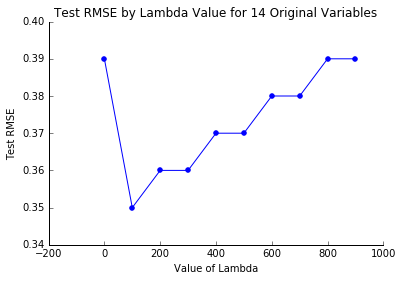

In [27]:
print lambda_list
print test_rmse_list

plt.plot(lambda_list, test_rmse_list)
# set variables for plot
y = np.vstack(test_rmse_list)
x = np.vstack(lambda_list)

# create scatter plot of price on rooms per house
plt.scatter(x, y, color = 'b')

# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off
# set x axis limits
#plt.gca().set_xlim([2,10])
# apply labels
plt.gca().set_xlabel('Value of Lambda')
plt.gca().set_ylabel('Test RMSE')
plt.gca().set_title('Test RMSE by Lambda Value for 14 Original Variables')

Using the 14 original variables inthis model performed the best by far, producing an average test RMSE of .37 over 10 values of lambda. The optimal lambda value apears to be ~ 100 in this model, which resulted in a Test RMSE of .35. Overall, the average training RMSE (.68) was higher than with previous models. But obviously the better Test RMSE was the primary goal. Cross-validation and lambda appear to have reduced the overfitting problem that plagued earlier attempts.

### (Showoff) Extra Credit 3: Lambda and coefficients

If you're feeling extra-special, create a parameter plot that shows how the different coefficient estimates change as a function of lambda. To make this graph intelligible, only include the *K* original F_s features in this plot

In [22]:
# assign variables (standardized)
y = np.ravel(np.vstack(standardize(bdata.target)))
xvalue_matrix = standardize(bdf)

lamvalues = []
coeffs = []
cols = xvalue_matrix.columns

# regress for 10 values of lambda, save coefficient values
for lam in range(0,1000,100):
    alphahat, betahats, count = multivariate_ols_lam(xvalue_matrix, y, lam, R=0.01, MaxIterations=10000)
    lamvalues.append(lam)
    coeffs.append(betahats)



Time taken: 0.83 seconds
Time taken: 0.83 seconds
Time taken: 0.88 seconds
Time taken: 0.84 seconds
Time taken: 0.78 seconds
Time taken: 0.79 seconds
Time taken: 0.83 seconds
Time taken: 0.87 seconds
Time taken: 0.86 seconds
Time taken: 0.84 seconds


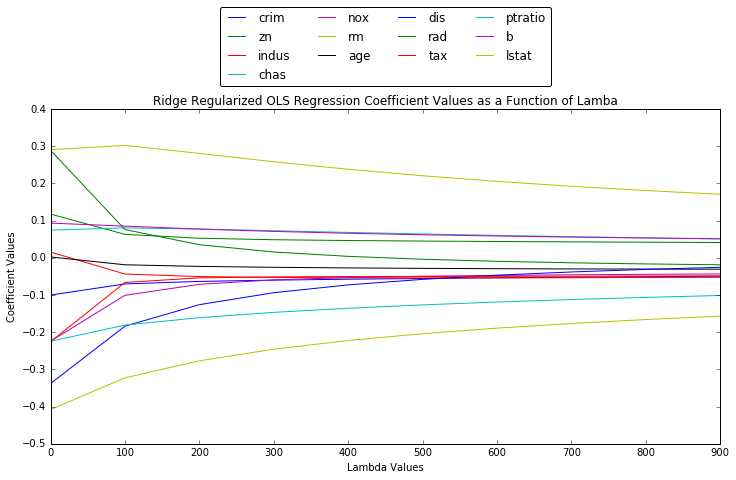

In [23]:
# transform lists to np arrays before making pd dataframe
coeffs = np.array(coeffs)
lamvalues = np.array(lamvalues)

# get lists into pd dataframe for easier plotting, use cols for column names and lamvalues as index
lam_coeffs_df = pd.DataFrame(coeffs)
lam_coeffs_df.columns = cols
lam_coeffs_df['lam'] = lamvalues
lam_coeffs_df_indexed = lam_coeffs_df.set_index(lam_coeffs_df['lam'])

# drop lambda column (values held in index)
lam_coeffs_df_indexed.drop('lam', axis = 1, inplace = True)

# make plot
lamplot = lam_coeffs_df_indexed.plot(subplots=False, figsize=(12, 6)); plt.legend(loc='best')
lamplot.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=False)

# add labels
plt.gca().set_xlabel('Lambda Values')
plt.gca().set_ylabel('Coefficient Values')
plt.gca().set_title('Ridge Regularized OLS Regression Coefficient Values as a Function of Lamba')

As lambda increases in the regularized regression, the coefficient values all tend to 0. There is a distinct bend in the slopes of the lines around Lambda = 100. This is also the value at which the regression produces alpha-hat and beta-hat coefficients that result in the lowest Test RMSE.